## **1 - Pre-process data**

## 0) Download and load data, add libraries...

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
filename = 'players.csv'

'players.csv'

In [ ]:
data= pd.read_csv(filename)

## 1) Check and eliminate null values (cleaned_data)

In [7]:
# See null value by columns
print(data.isnull().sum())

player_id                                   0
first_name                               2058
last_name                                   0
name                                        0
last_season                                 0
current_club_id                             0
player_code                                 0
country_of_birth                         2797
city_of_birth                            2455
country_of_citizenship                    380
date_of_birth                              47
sub_position                              185
position                                    0
foot                                     2594
height_in_cm                             2340
contract_expiration_date                12124
agent_name                              16010
image_url                                   0
url                                         0
current_club_domestic_competition_id        0
current_club_name                           0
market_value_in_eur               

In [8]:
# Percentage of null values by columns
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

player_id                                0.000000
first_name                               6.350480
last_name                                0.000000
name                                     0.000000
last_season                              0.000000
current_club_id                          0.000000
player_code                              0.000000
country_of_birth                         8.630851
city_of_birth                            7.575524
country_of_citizenship                   1.172586
date_of_birth                            0.145030
sub_position                             0.570864
position                                 0.000000
foot                                     8.004443
height_in_cm                             7.220662
contract_expiration_date                37.411670
agent_name                              49.402907
image_url                                0.000000
url                                      0.000000
current_club_domestic_competition_id     0.000000


In [9]:
from datetime import datetime

# Columns to check for null, 0, None, or N/A values
columns_to_check = [
    'date_of_birth',
    'position',
    'foot',
    'height_in_cm',
    'contract_expiration_date',
    'highest_market_value_in_eur',
    'current_club_domestic_competition_id',
    'market_value_in_eur'
]

# Replace problematic values ('N/A', 'None', or 0) with NaN
data.replace(['N/A', 'None', 0, 'NaN'], pd.NA, inplace=True)

# Drop rows with null values in the specified columns
cleaned_data = data.dropna(subset=columns_to_check)

# I also want to work only with current players
# So samples where the contract_expiration_date is before today are deleted
cleaned_data = cleaned_data[cleaned_data['contract_expiration_date'] > datetime.today().strftime('%Y-%m-%d')]

# Check how many rows were removed
num_removed = len(data) - len(cleaned_data)
print(f"Number of rows removed: {num_removed}")
print(f"Number of rows remaining: {len(cleaned_data)}")

Number of rows removed: 22199
Number of rows remaining: 10208


In [10]:
# Just to see an example
print(cleaned_data[cleaned_data['last_name']=="Paredes"])

       player_id first_name last_name             name  last_season  \
10803     166237    Leandro   Paredes  Leandro Paredes         2024   
25970     591916      Aitor   Paredes    Aitor Paredes         2024   
28556     711517      Kevin   Paredes    Kevin Paredes         2024   

       current_club_id      player_code country_of_birth  \
10803               12  leandro-paredes        Argentina   
25970              621    aitor-paredes            Spain   
28556               82    kevin-paredes    United States   

                city_of_birth country_of_citizenship  ...   foot height_in_cm  \
10803               San Justo              Argentina  ...  right        180.0   
25970                  Bilbao                  Spain  ...  right        185.0   
28556  South Riding, Virginia          United States  ...   left        175.0   

      contract_expiration_date   agent_name  \
10803      2025-06-30 00:00:00   DCGLOBALSL   
25970      2029-06-30 00:00:00  CAA Stellar   
28556   

## 2) Balance the data and check outliers

Initial class distribution:
Classification_Label
1    5718
2    2985
3     837
4     668
Name: count, dtype: int64
Balanced Distribution:
Classification_Label
3    837
1    800
2    800
4    668
Name: count, dtype: int64


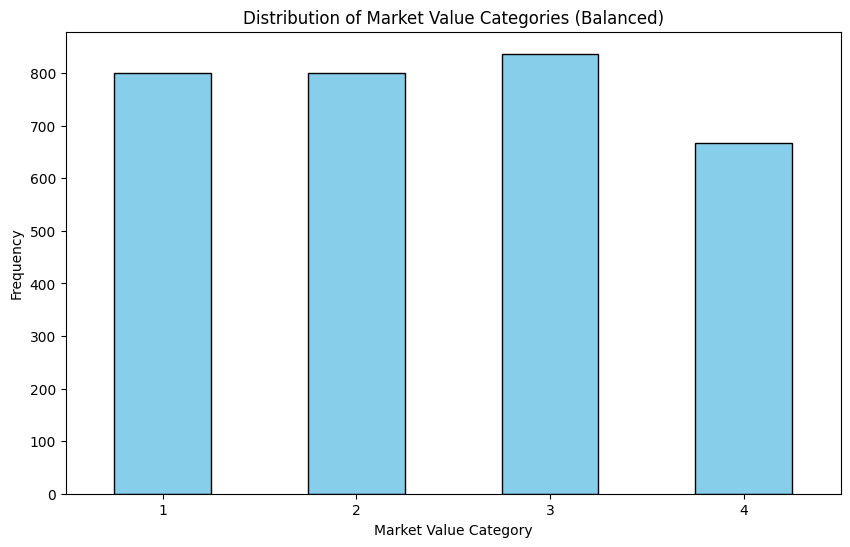

In [11]:
# Code to get the balanced data to start working on it

# Define bins based on the distribution of market values
market_values = cleaned_data['market_value_in_eur'].dropna()
# Example bin edges - adjust as necessary to create balanced classes
bins = [0, 1e6, 6e6, 15e6, market_values.max()]  # Example bin edges
labels = [1, 2, 3, 4]  # Corresponding category labels

# Crear la columna de clasificación
cleaned_data.loc[:,'Classification_Label'] = pd.cut(cleaned_data['market_value_in_eur'], bins=bins, labels=labels, include_lowest=True)

# Check the initial class distribution
print("Initial class distribution:")
print(cleaned_data['Classification_Label'].value_counts())

num_samples_class_1 = 800  # Number of players from class 1
num_samples_class_2 = 800  # Number of players from class 2

# Filter class 1 players
class_1_players = cleaned_data[cleaned_data['Classification_Label'] == 1]
# Filter class 2 players
class_2_players = cleaned_data[cleaned_data['Classification_Label'] == 2]

# Limit class 1 players
if len(class_1_players) > num_samples_class_1:
    class_1_players = class_1_players.sample(num_samples_class_1, random_state=42)

# Limit class 2 players
if len(class_2_players) > num_samples_class_2:
    class_2_players = class_2_players.sample(num_samples_class_2, random_state=42)

# Filter other classes
other_classes = cleaned_data[cleaned_data['Classification_Label'].isin([3,4])]

# Combine the classes
balanced_data = pd.concat([class_1_players, class_2_players, other_classes])
# Verify balanced distribution
print("Balanced Distribution:")
print(balanced_data['Classification_Label'].value_counts())

# Visualize distribution
plt.figure(figsize=(10, 6))
balanced_data['Classification_Label'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Market Value Categories (Balanced)")
plt.xlabel("Market Value Category")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

In [12]:
# Check that the important columns for our estimation have no missing values
missing_percentage = (balanced_data.isnull().sum() / len(balanced_data)) * 100
print(missing_percentage)

player_id                                0.000000
first_name                               7.471820
last_name                                0.000000
name                                     0.000000
last_season                              0.000000
current_club_id                          0.000000
player_code                              0.000000
country_of_birth                         2.930757
city_of_birth                            2.286634
country_of_citizenship                   0.676329
date_of_birth                            0.000000
sub_position                             0.000000
position                                 0.000000
foot                                     0.000000
height_in_cm                             0.000000
contract_expiration_date                 0.000000
agent_name                              26.892110
image_url                                0.000000
url                                      0.000000
current_club_domestic_competition_id     0.000000


In [13]:
#Remove outliers based on the the IQR. Outliers are typically considered values below or above some percentile
numerical_features = [
    'highest_market_value_in_eur',
    'market_value_in_eur'
]

# Create a copy of the data to avoid modifying the original directly
data_without_outliers = balanced_data.copy()

# Iterate over the numerical features to detect and remove outliers
for feature in numerical_features:
    Q1 = data_without_outliers[feature].quantile(0.1)  # 10th percentile
    Q3 = data_without_outliers[feature].quantile(0.9)  # 90th percentile
    IQR = Q3 - Q1  # Interquartile Range

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    data_without_outliers = data_without_outliers[
        (data_without_outliers[feature] >= lower_bound) &
        (data_without_outliers[feature] <= upper_bound)
    ]

# Print the number of rows before and after removing outliers
print(f"Number of rows before removing outliers: {len(balanced_data)}")
print(f"Number of rows after removing outliers: {len(data_without_outliers)}")


Number of rows before removing outliers: 3105
Number of rows after removing outliers: 3048


## 3) Analysis of the Labels

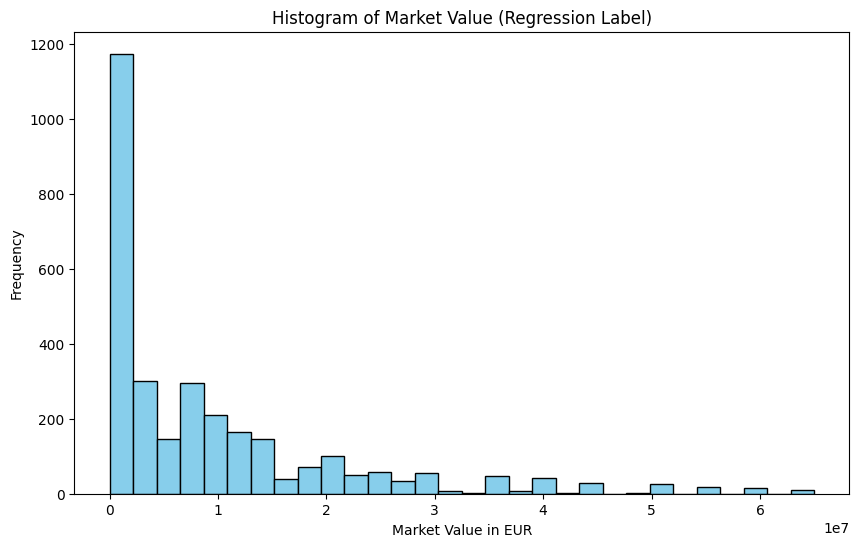

Number of records in each class:
Classification_Label
1    800
2    800
3    834
4    614
Name: count, dtype: int64


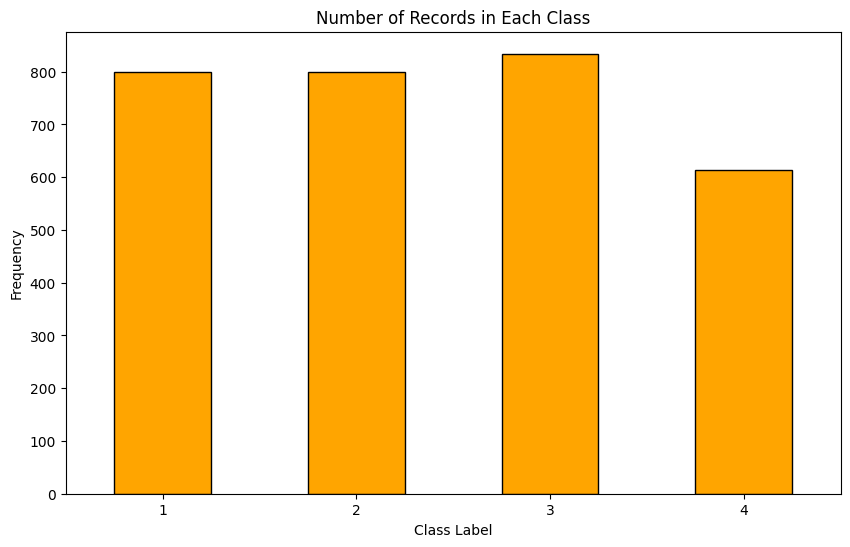

In [14]:
# Analyze the regression label
plt.figure(figsize=(10, 6))
plt.hist(data_without_outliers['market_value_in_eur'], bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Market Value (Regression Label)")
plt.xlabel("Market Value in EUR")
plt.ylabel("Frequency")
plt.show()

# Count the number of records for each class
class_counts = data_without_outliers['Classification_Label'].value_counts().sort_index()

# Display the counts
print("Number of records in each class:")
print(class_counts)

# Visualize the class distribution as a bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Number of Records in Each Class")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

## 4) Columns encoding

In [15]:
from sklearn.preprocessing import LabelEncoder

# To keep accesible the original market value without being normalized
data_without_outliers['market_value_orig'] = data_without_outliers['market_value_in_eur']

# Important Columns to keep
columns_to_keep = [
    'date_of_birth',
    'position',
    'foot',
    'height_in_cm',
    'contract_expiration_date',
    'market_value_in_eur',
    'market_value_orig',
    'highest_market_value_in_eur',
    'current_club_domestic_competition_id',
    'Classification_Label'
]

# Filter the data to keep only the necessary columns
dt = data_without_outliers[columns_to_keep].copy()

# Transform 'date_of_birth' into age
dt['date_of_birth'] = pd.to_datetime(dt['date_of_birth'], errors='coerce')
today = datetime.today()
dt['age_in_years'] = (today - dt['date_of_birth']).dt.days // 365
dt.drop(columns=['date_of_birth'], inplace=True)

# Transform 'contract_expiration_date' into days until expiration
dt['contract_expiration_date'] = pd.to_datetime(dt['contract_expiration_date'], errors='coerce')
dt['days_until_expiration'] = (dt['contract_expiration_date'] - today).dt.days
dt.drop(columns=['contract_expiration_date'], inplace=True)

# Encode 'position' column with unique numbers
dt['position'] = dt['position'].astype('category').cat.codes
#'Attack'= 0, 'Defender' = 1, 'Goalkeeper' = 2, 'Midfield' = 3

# Encode 'foot' column
dt['foot'] = dt['foot'].map({'left': 0, 'right': 1})

# Encode 'current_club_domestic_competition_id' with unique numbers
dt['current_club_domestic_competition_id'] = dt['current_club_domestic_competition_id'].astype('category').cat.codes

# Reorder columns to make 'Classification_Label' the last column
columns_order = [col for col in dt.columns if col != 'Classification_Label'] + ['Classification_Label']
dt = dt[columns_order]


# Handle missing values that might have been introduced during the transformation
dt.dropna(inplace=True)

# Verify the data types after transformation
print("\nData types after transformation:")
print(dt.dtypes)
print(dt.head())


Data types after transformation:
position                                    int8
foot                                     float64
height_in_cm                             float64
market_value_in_eur                      float64
market_value_orig                        float64
highest_market_value_in_eur              float64
current_club_domestic_competition_id        int8
age_in_years                               int64
days_until_expiration                      int64
Classification_Label                    category
dtype: object
       position  foot  height_in_cm  market_value_in_eur  market_value_orig  \
17983         0   1.0         170.0             700000.0           700000.0   
22774         1   1.0         197.0             400000.0           400000.0   
28208         1   0.0         189.0             400000.0           400000.0   
25592         3   1.0         190.0             750000.0           750000.0   
29960         2   1.0         188.0             100000.0           

<ipython-input-15-81084f6e25f9>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt.dropna(inplace=True)


In [16]:
# Check the final column order
print("Final column order:")
print(dt.columns)

Final column order:
Index(['position', 'foot', 'height_in_cm', 'market_value_in_eur',
       'market_value_orig', 'highest_market_value_in_eur',
       'current_club_domestic_competition_id', 'age_in_years',
       'days_until_expiration', 'Classification_Label'],
      dtype='object')


## 5) Columns Normalization

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Identify numerical columns to normalize
# Not including the market value column because it is the regression label
numerical_columns = [
    'height_in_cm',
    'highest_market_value_in_eur',
    'age_in_years',
    'days_until_expiration',
    'market_value_in_eur'
]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max scaling to the numerical columns
dt[numerical_columns] = scaler.fit_transform(dt[numerical_columns])

# Check the normalized data
print("Normalized data:")
print(dt[numerical_columns].head())

Normalized data:
       height_in_cm  highest_market_value_in_eur  age_in_years  \
17983      0.181818                     0.012401          0.36   
22774      0.795455                     0.003900          0.36   
28208      0.613636                     0.003900          0.32   
25592      0.636364                     0.019902          0.28   
29960      0.590909                     0.000900          0.12   

       days_until_expiration  market_value_in_eur  
17983               0.058331             0.010617  
22774               0.293587             0.006001  
28208               0.048663             0.006001  
25592               0.411537             0.011386  
29960               0.058331             0.001385  


## **2- DATA VISUALIZATION**

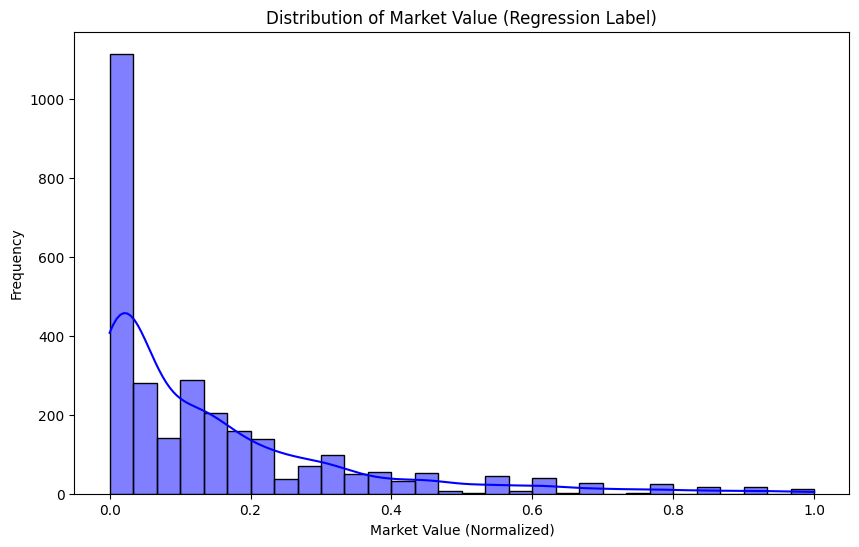

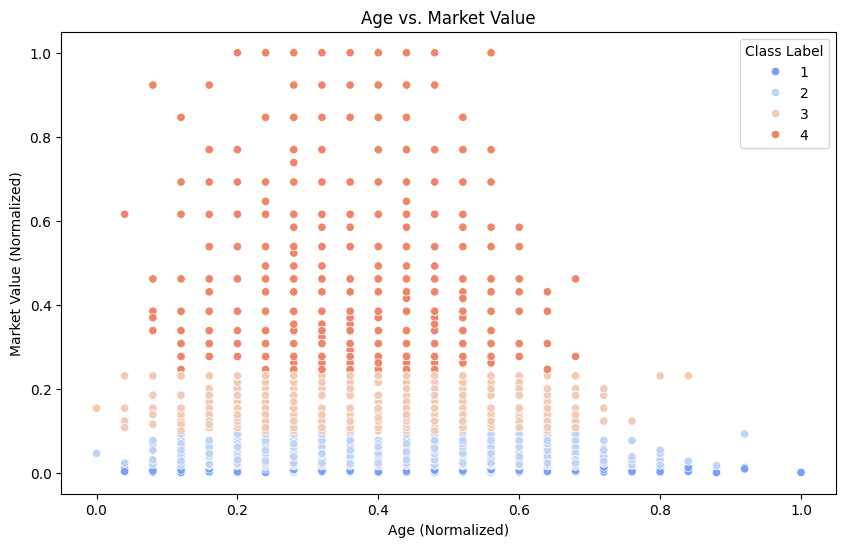

<ipython-input-18-ded0867fd8ee>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=dt, x='position', y='market_value_in_eur', palette='Set2')
<ipython-input-18-ded0867fd8ee>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(position_labels)


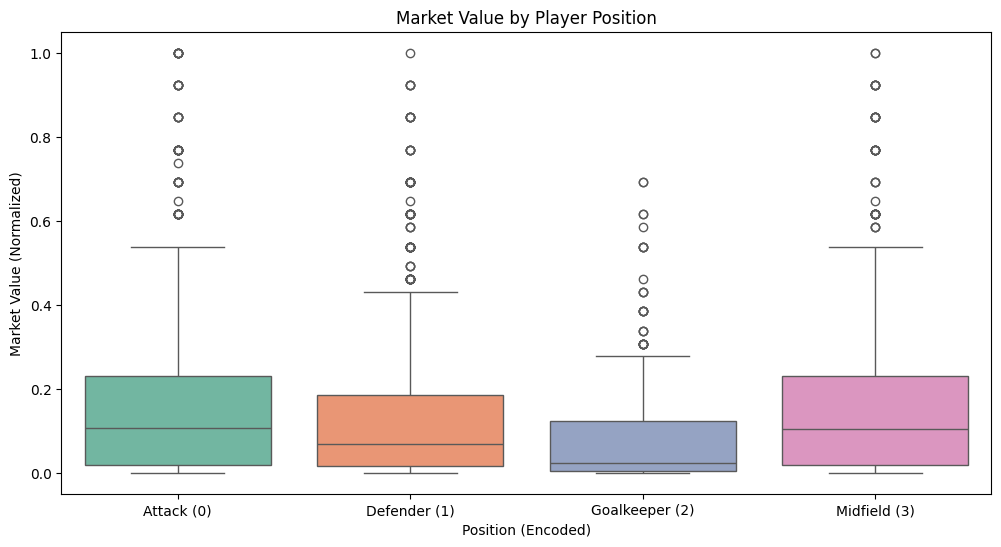

<ipython-input-18-ded0867fd8ee>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=dt, x='Classification_Label', y='market_value_in_eur', palette='muted')
<ipython-input-18-ded0867fd8ee>:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_labels)


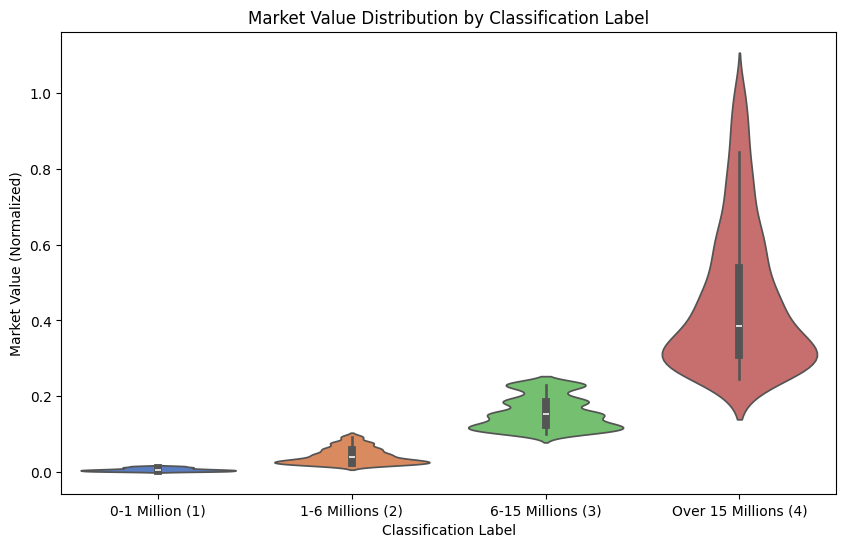

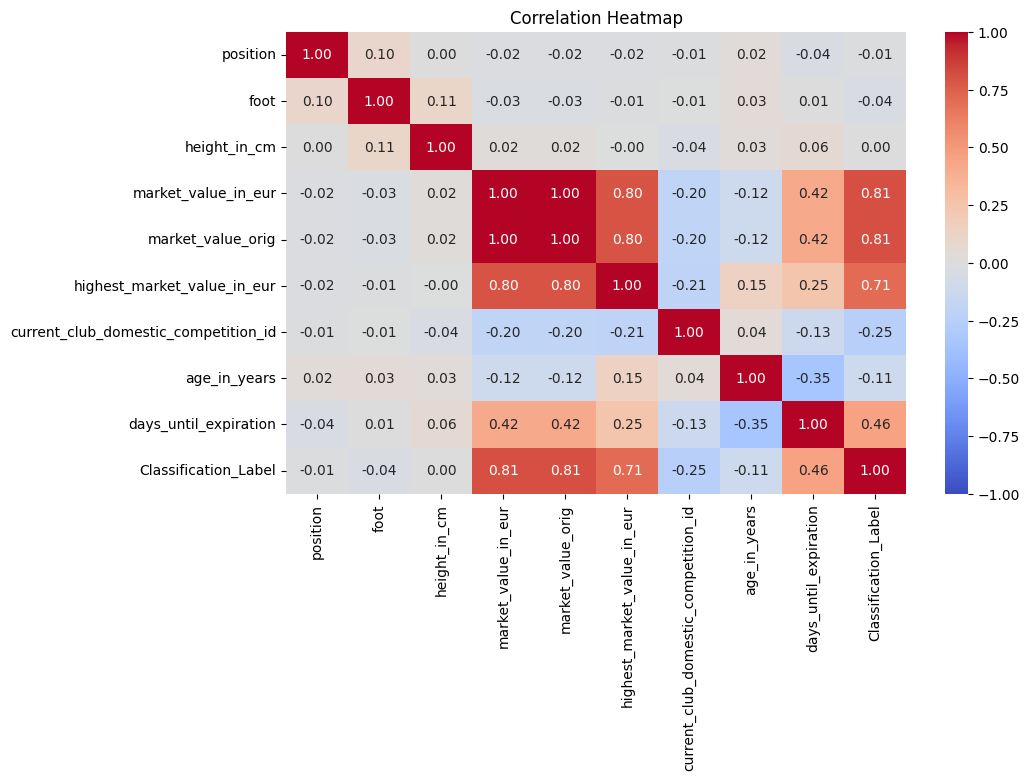

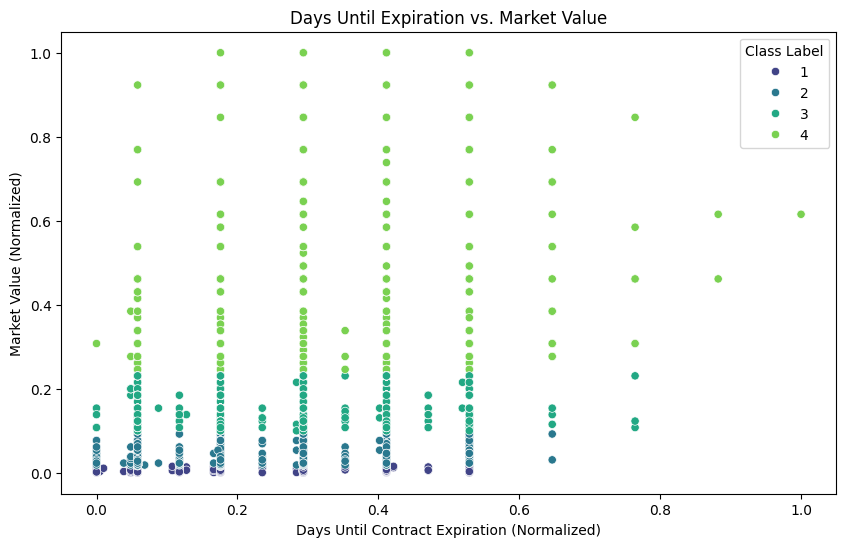

In [18]:
import seaborn as sns

# 0. Distribution of Market Value (Regression Label)
plt.figure(figsize=(10, 6))
sns.histplot(data=dt, x='market_value_in_eur', bins=30, kde=True, color='blue')
plt.title('Distribution of Market Value (Regression Label)')
plt.xlabel('Market Value (Normalized)')
plt.ylabel('Frequency')
plt.show()

# Explanation:
# This plot shows the distribution of the market_value_in_eur.
# It helps us understand the range and density of values after normalization, which is critical for regression analysis.

# 1. Age vs. Market Value
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dt, x='age_in_years', y='market_value_in_eur', hue='Classification_Label', palette='coolwarm')
plt.title('Age vs. Market Value')
plt.xlabel('Age (Normalized)')
plt.ylabel('Market Value (Normalized)')
plt.legend(title='Class Label')
plt.show()

# Explanation:
# This scatter plot examines the relationship between `age_in_years` and `market_value_in_eur`.
# It's helpful to explore trends, such as whether younger players tend to have higher market values.
# It can be observed that older players usually have a lower market value

# 2. Market Value by Position
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=dt, x='position', y='market_value_in_eur', palette='Set2')
position_labels = ['Attack (0)', 'Defender (1)', 'Goalkeeper (2)', 'Midfield (3)']
ax.set_xticklabels(position_labels)
plt.title('Market Value by Player Position')
plt.xlabel('Position (Encoded)')
plt.ylabel('Market Value (Normalized)')
plt.show()

# Explanation:
# The box plot shows how market value varies by player position.
# This can help determine if certain positions are associated with higher values.
# We can confirm that the goalkeepers have usually lower market values.

# 3. Market Value Distribution by Class
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=dt, x='Classification_Label', y='market_value_in_eur', palette='muted')
class_labels = ['0-1 Million (1)', '1-6 Millions (2)', '6-15 Millions (3)', 'Over 15 Millions (4)']
ax.set_xticklabels(class_labels)
plt.title('Market Value Distribution by Classification Label')
plt.xlabel('Classification Label')
plt.ylabel('Market Value (Normalized)')
plt.show()

# Explanation:
# This violin plot shows the distribution of market values within each classification label.
# It provides insights into class overlap and the separability of the data for classification tasks.

# 4. Correlation Heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = dt.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Explanation:
# The heatmap highlights correlations between features.
# It helps identify which features are strongly related to market value or other variables, aiding feature selection.
# As we could expect, the highest market value is highly correlated with the market value as its value is close to 1 (0.8)

# 5. Days Until Expiration vs. Market Value
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dt, x='days_until_expiration', y='market_value_in_eur', hue='Classification_Label', palette='viridis')
plt.title('Days Until Expiration vs. Market Value')
plt.xlabel('Days Until Contract Expiration (Normalized)')
plt.ylabel('Market Value (Normalized)')
plt.legend(title='Class Label')
plt.show()

# Explanation:
# This scatter plot explores the relationship between `days_until_expiration` and `market_value_in_eur`.
# There are not many players with very long contracts but the ones that exist have usually higher market values

## **3- Problem Statement**

# Regression
*   The label is the column called "Classification_ Label" and the features are the columns: 'position', 'foot', 'height_in_cm',
       'highest_market_value_in_eur', 'current_club_domestic_competition_id',
       'age_in_years', 'days_until_expiration'

*   Yes, it makes sense to use these features to predict the label. As an example, estimating the market value of a soccer player based on its age makes sense because the older he is, the lower the price is.

*   The metrics used to compare the performance of the regression models will be the MSE, histogram of residuals and the R^2 Score.

# Classification
*   In order to have balanced clases I have created the Classification_Label with the following 4 ranges:
From 0 to 1 Million market value
From 1 to 6 Millions market value
From 6 to 25 Millions market value
More than 25 Millions market value

*  The classification models´performance will be compared thanks to the Accuracy metric, F-1 Score (precision/recall) and the confusion matrix.








## **4- Features Selection**

<Axes: >

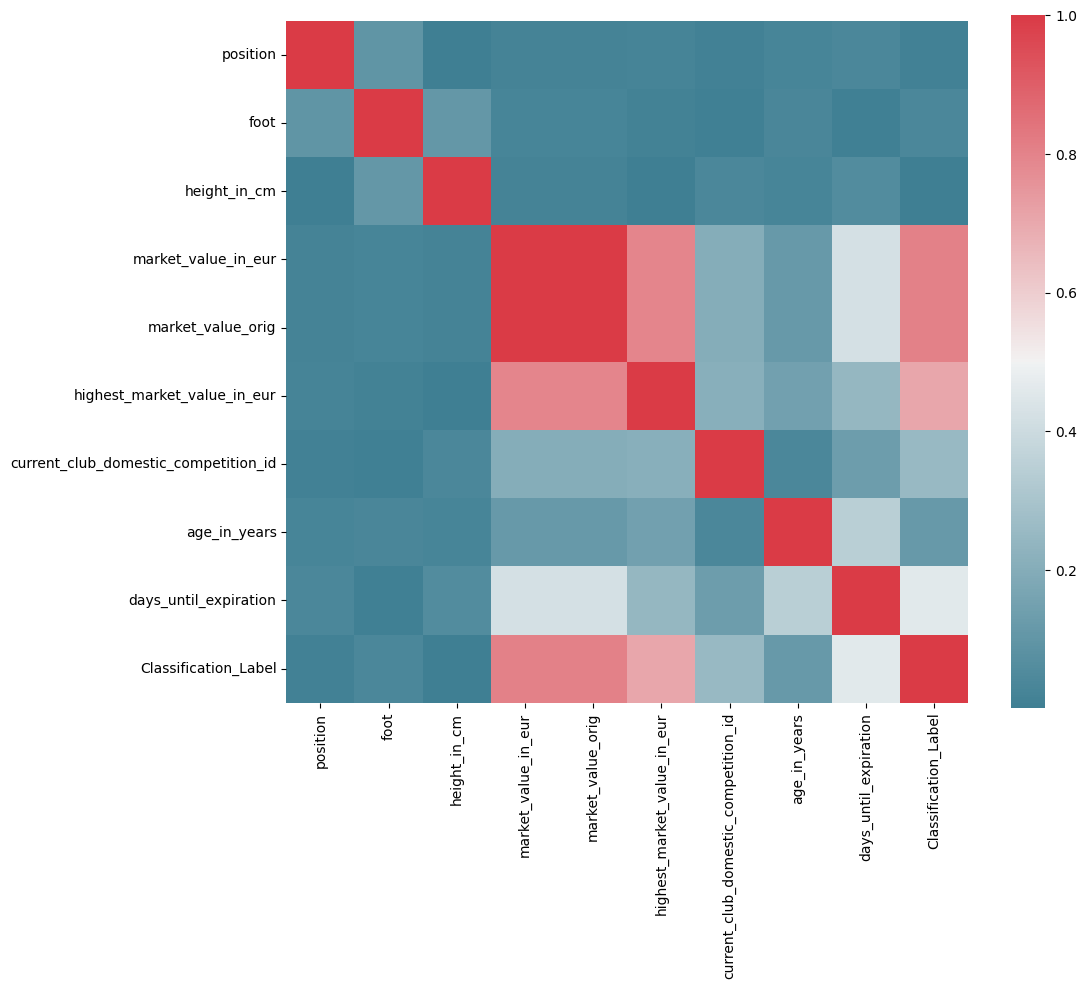

In [19]:
import seaborn as sns
corr = abs(dt.corr())

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask = np.zeros_like(corr, dtype=np.bool_), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

We can see that the features **'market_value_in_eur' and 'highest_market_value_in_eur' are highly correlated** because their mutual color in the correlation plot is pink. However, as I do not have so many features (just 8) and my model is not that complex, I am not deleting it and I will stay with both of them.

Then, the features 'market_value_in_eur' and 'market_value_orig' are obviously with maximum correlation because they are the same feature but one is normalized and the other not.

So my final feature selection is:

 1   position

 2   foot

 3   height_in_cm

 4   highest_market_value_in_eur

 5   current_club_domestic_competition_id

 6   age_in_years

 7   days_until_expiration     

 And the labels:

 8   market_value_in_eur (Regression Label)

 9   Classification_Label (Classification Label)

## **5- Models Comparison**

## 1) Regression

Linear Regression

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = dt.drop(columns=['Classification_Label','market_value_in_eur','market_value_orig']) # I want to train the model without the labels
Y = dt['market_value_in_eur'] # The Regression label

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

MSE (Train): 0.0099
MSE (Test): 0.0116
R2 (Train): 0.7286
R2 (Test): 0.6657


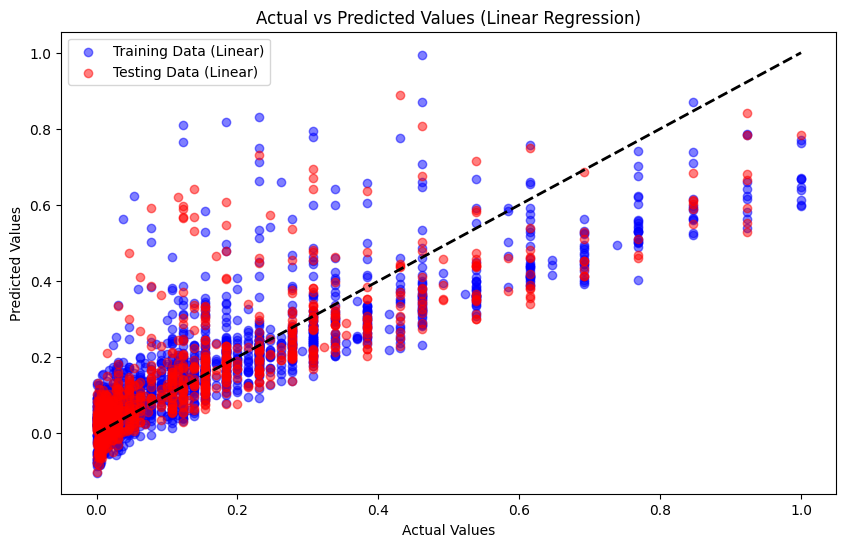

In [21]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_train_pred_lin = model.predict(X_train)
Y_test_pred_lin = model.predict(X_test)

# Evaluation metrics
mse_train_lin = mean_squared_error(Y_train, Y_train_pred_lin)
mse_test_lin = mean_squared_error(Y_test, Y_test_pred_lin)
r2_train_lin = r2_score(Y_train, Y_train_pred_lin)
r2_test_lin = r2_score(Y_test, Y_test_pred_lin)

print(f'MSE (Train): {mse_train_lin:.4f}')
print(f'MSE (Test): {mse_test_lin:.4f}')
print(f'R2 (Train): {r2_train_lin:.4f}')
print(f'R2 (Test): {r2_test_lin:.4f}')

# Plotting Actual vs Predicted Values for Polynomial Regression
plt.figure(figsize=(10, 6))
plt.scatter(Y_train, Y_train_pred_lin, label='Training Data (Linear)', alpha=0.5, color='blue')
plt.scatter(Y_test, Y_test_pred_lin, label='Testing Data (Linear)', alpha=0.5, color='red')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='black', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Values (Linear Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

ExactExplainer explainer: 2043it [00:23, 24.76it/s]                          


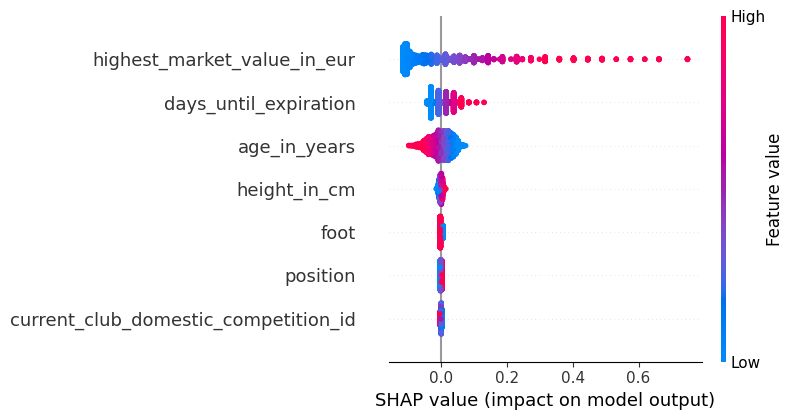

In [26]:
# Features impact
import shap

# Initialize the SHAP explainer for the linear regression model
explainer = shap.Explainer(model.predict, X_train)

# Calculate SHAP values
shap_values = explainer(X_train)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_train)

This graph shows the importance of each feature in the model's predictions. We can see that the historical highest market value has much weight in the predictions. On the other hand, a feature like the current competition has not that much importance

Polynomial Regression

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create polynomial features
degree = 2  # Change this to try higher degrees
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the polynomial regression model
poly_model.fit(X_train, Y_train)

# Make predictions
Y_train_pred_poly = poly_model.predict(X_train)
Y_test_pred_poly = poly_model.predict(X_test)

Polynomial Degree: 2
MSE (Train - Polynomial): 0.0051
MSE (Test - Polynomial): 0.0068
R2 (Train - Polynomial): 0.8597
R2 (Test - Polynomial): 0.8052


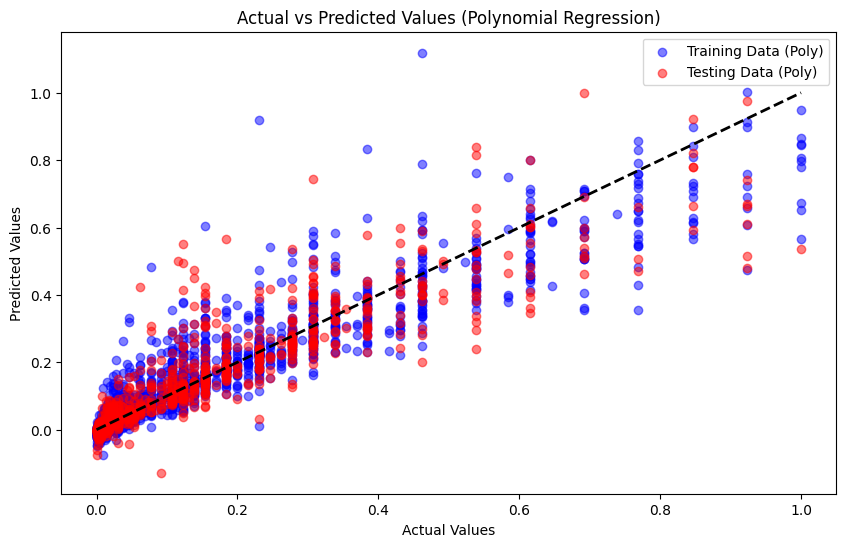

In [29]:
# Evaluation metrics for polynomial regression
mse_train_poly = mean_squared_error(Y_train, Y_train_pred_poly)
mse_test_poly = mean_squared_error(Y_test, Y_test_pred_poly)
r2_train_poly = r2_score(Y_train, Y_train_pred_poly)
r2_test_poly = r2_score(Y_test, Y_test_pred_poly)

print(f'Polynomial Degree: {degree}')
print(f'MSE (Train - Polynomial): {mse_train_poly:.4f}')
print(f'MSE (Test - Polynomial): {mse_test_poly:.4f}')
print(f'R2 (Train - Polynomial): {r2_train_poly:.4f}')
print(f'R2 (Test - Polynomial): {r2_test_poly:.4f}')

# Plotting Actual vs Predicted Values for Polynomial Regression
plt.figure(figsize=(10, 6))
plt.scatter(Y_train, Y_train_pred_poly, label='Training Data (Poly)', alpha=0.5, color='blue')
plt.scatter(Y_test, Y_test_pred_poly, label='Testing Data (Poly)', alpha=0.5, color='red')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='black', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Values (Polynomial Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

ExactExplainer explainer: 2043it [00:42, 34.27it/s]                          


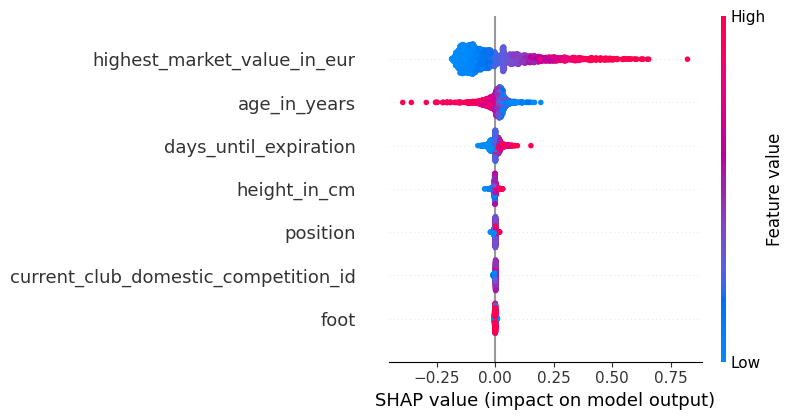

In [30]:
# Features impact
# Initialize the SHAP explainer for the linear regression model
explainer = shap.Explainer(poly_model.predict, X_train)

# Calculate SHAP values
shap_values = explainer(X_train)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_train)

In the polynomial model, the highest market value has also been the feature with most impact on the model output. However, together with the current competition, the foot has also had a small impact on the predictions.

Support Vector Regression (SVR) with GridSearch

Best Hyperparameters:
{'C': 100, 'gamma': 0.1}
MSE (Train - SVR): 0.0057
MSE (Test - SVR): 0.0089
R2 (Train - SVR): 0.8453
R2 (Test - SVR): 0.7454


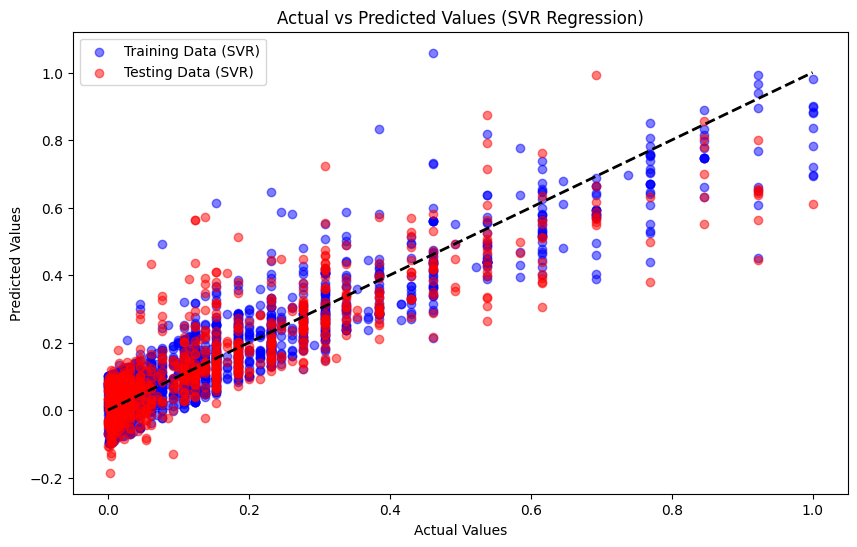

In [31]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
}

# Create the model
svr_model = SVR(kernel='rbf')

# Create the GridSearchCV object
grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='neg_mean_squared_error')  # Use negative MSE for minimization

# Fit the grid search to the training data
grid_search.fit(X_train, Y_train)

# Get the best model with tuned hyperparameters
best_svr = grid_search.best_estimator_
# Print the best hyperparameters found by GridSearchCV
print('Best Hyperparameters:')
print(grid_search.best_params_)

Y_train_pred_svr = best_svr.predict(X_train)
Y_test_pred_svr = best_svr.predict(X_test)

# Evaluate SVR
mse_train_svr = mean_squared_error(Y_train, Y_train_pred_svr)
mse_test_svr = mean_squared_error(Y_test, Y_test_pred_svr)
r2_train_svr = r2_score(Y_train, Y_train_pred_svr)
r2_test_svr = r2_score(Y_test, Y_test_pred_svr)

print(f'MSE (Train - SVR): {mse_train_svr:.4f}')
print(f'MSE (Test - SVR): {mse_test_svr:.4f}')
print(f'R2 (Train - SVR): {r2_train_svr:.4f}')
print(f'R2 (Test - SVR): {r2_test_svr:.4f}')

# Plotting Actual vs Predicted Values for SV Regression
plt.figure(figsize=(10, 6))
plt.scatter(Y_train, Y_train_pred_svr, label='Training Data (SVR)', alpha=0.5, color='blue')
plt.scatter(Y_test, Y_test_pred_svr, label='Testing Data (SVR)', alpha=0.5, color='red')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='black', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Values (SVR Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

ExactExplainer explainer: 2043it [08:08,  4.15it/s]


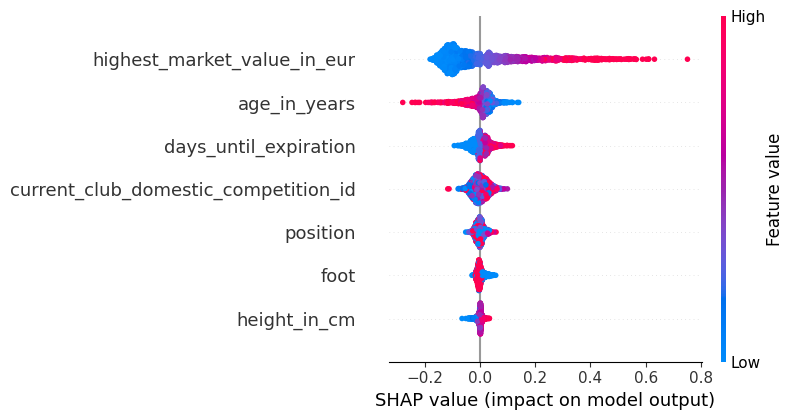

In [32]:
# Features impact
# Initialize the SHAP explainer for the linear regression model
explainer = shap.Explainer(best_svr.predict, X_train)

# Calculate SHAP values
shap_values = explainer(X_train)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_train)

Even though the highest market value is still the feature with more impact on the output, we can see that the rest of the features have more impact than before. This means that this model is more complete as it takes all the features into account.

3 Regression Models Comparison

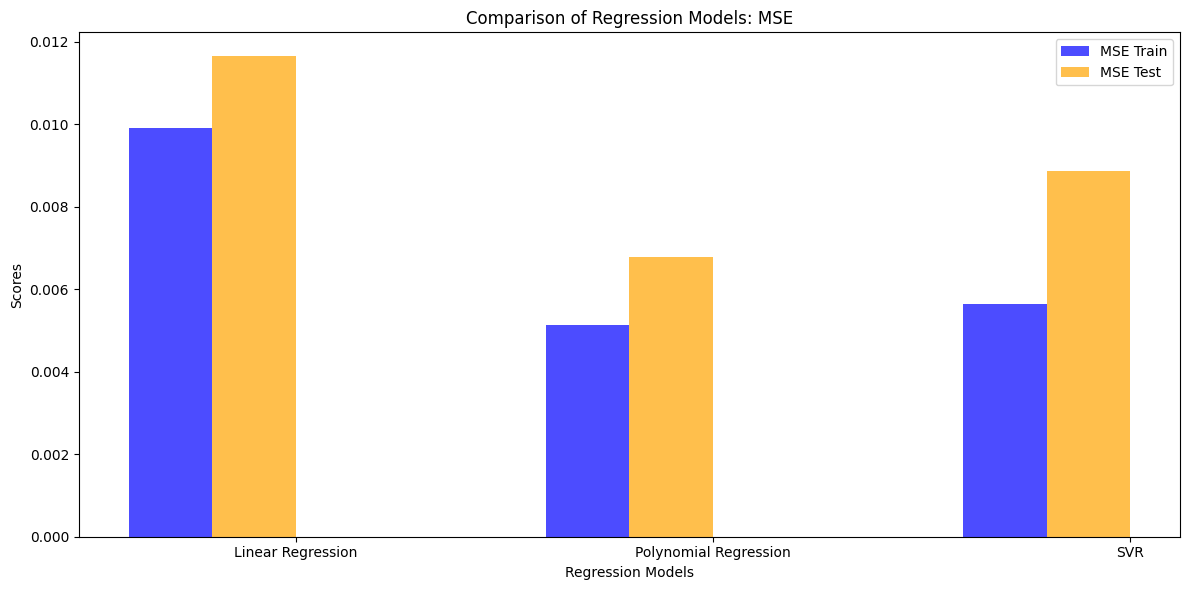

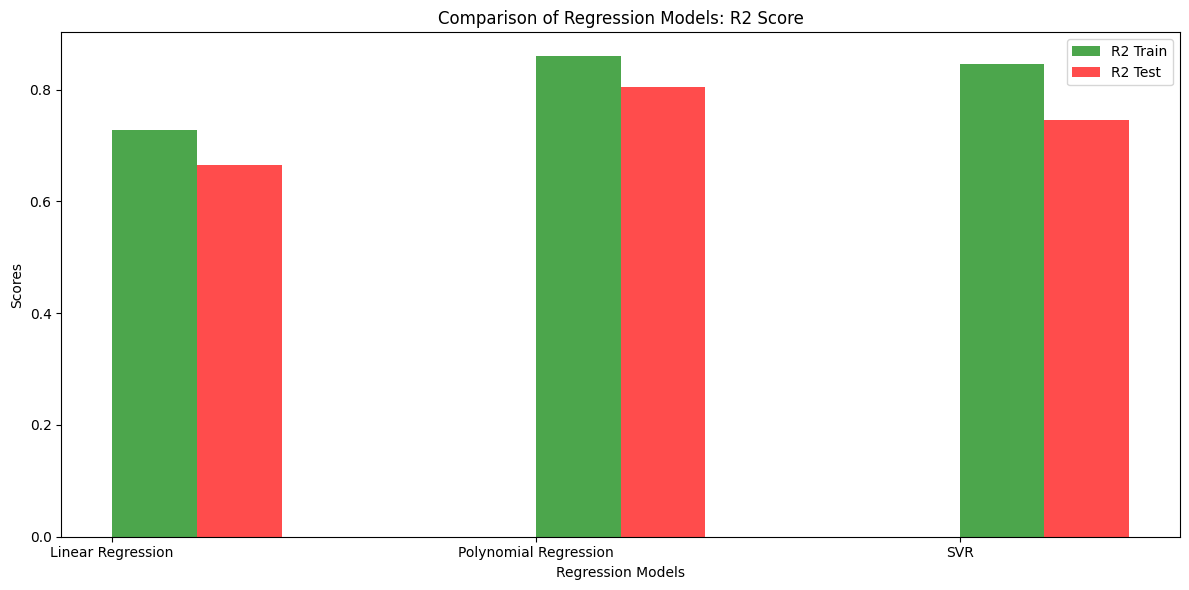

In [33]:
models = ['Linear Regression', 'Polynomial Regression', 'SVR']
mse_train = [mse_train_lin, mse_train_poly, mse_train_svr]
mse_test = [mse_test_lin, mse_test_poly, mse_test_svr]
r2_train = [r2_train_lin, r2_train_poly, r2_train_svr]
r2_test = [r2_test_lin, r2_test_poly, r2_test_svr]

# Plot settings
x = np.arange(len(models))  # Number of models
width = 0.2  # Width of each bar

# Create a figure
plt.figure(figsize=(12, 6))

# MSE comparison
plt.bar(x - width, mse_train, width, label='MSE Train', color='blue', alpha=0.7)
plt.bar(x, mse_test, width, label='MSE Test', color='orange', alpha=0.7)

# Add labels and titles
plt.xticks(x + width / 2, models)
plt.xlabel('Regression Models')
plt.ylabel('Scores')
plt.title('Comparison of Regression Models: MSE')
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

plt.figure(figsize=(12, 6))
# R2 comparison
plt.bar(x + width, r2_train, width, label='R2 Train', color='green', alpha=0.7)
plt.bar(x + 2 * width, r2_test, width, label='R2 Test', color='red', alpha=0.7)

# Add labels and titles
plt.xticks(x + width / 2, models)
plt.xlabel('Regression Models')
plt.ylabel('Scores')
plt.title('Comparison of Regression Models: R2 Score')
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

From the metrics comparison we can state that the Polynomial Regression is the best Regression model as it has the lowest MSE value and the higher R2 Score.

The SVR model is also a good model, being the second best option as it has improved its performance thanks to the GridSearch of the best parameters.

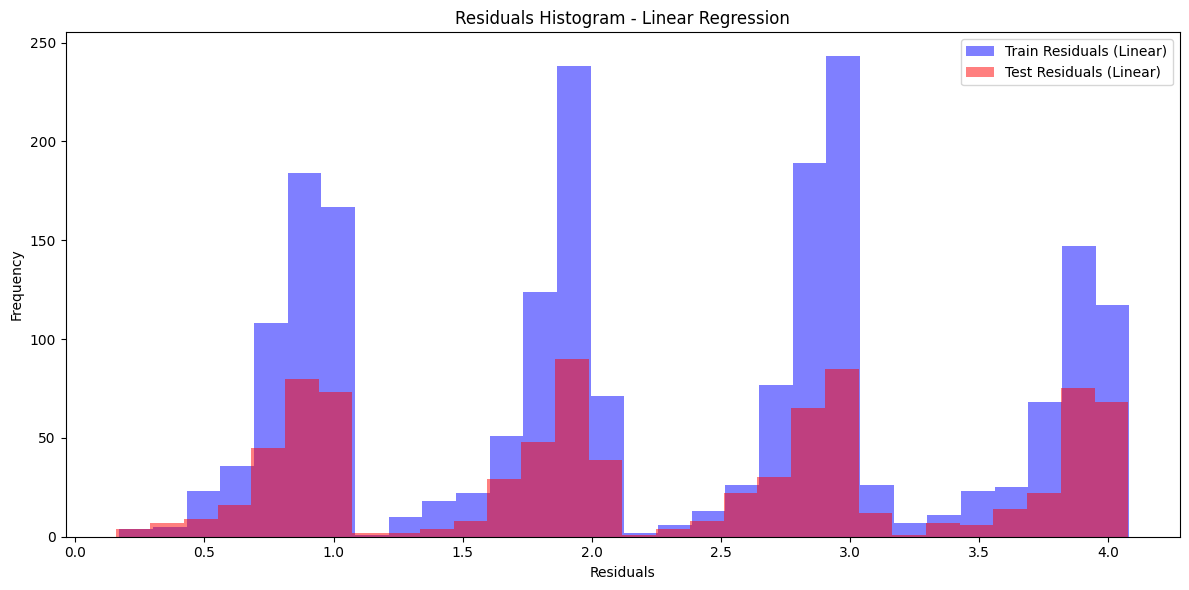

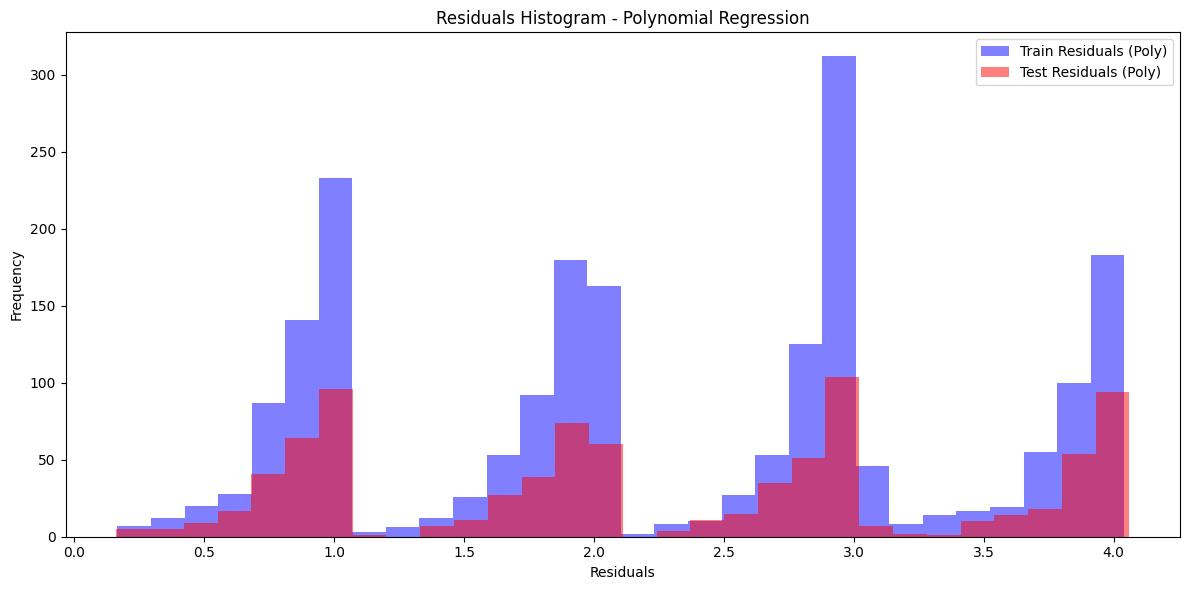

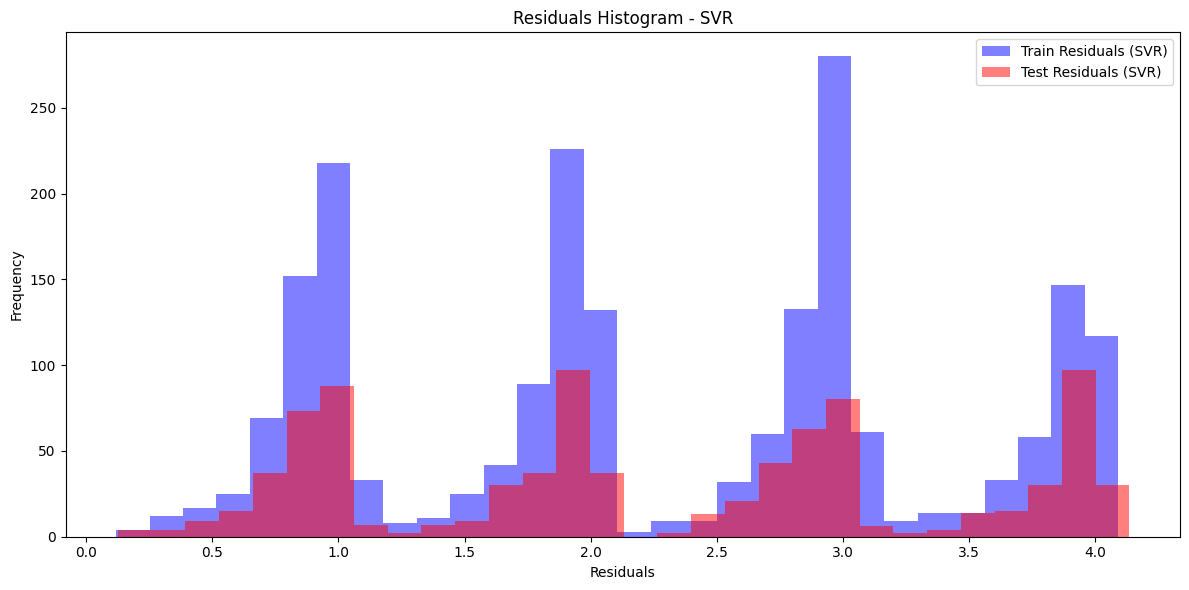

In [61]:
# Ensure Y_train and Y_test are numeric
Y_train = pd.to_numeric(Y_train, errors='coerce')
Y_test = pd.to_numeric(Y_test, errors='coerce')

# Compute residuals for each model
residuals_train_lin = Y_train - Y_train_pred_lin
residuals_test_lin = Y_test - Y_test_pred_lin

residuals_train_poly = Y_train - Y_train_pred_poly
residuals_test_poly = Y_test - Y_test_pred_poly

residuals_train_svr = Y_train - Y_train_pred_svr
residuals_test_svr = Y_test - Y_test_pred_svr

# Plot histograms of residuals for Linear Regression
plt.figure(figsize=(12, 6))
plt.hist(residuals_train_lin, bins=30, alpha=0.5, label='Train Residuals (Linear)', color='blue')
plt.hist(residuals_test_lin, bins=30, alpha=0.5, label='Test Residuals (Linear)', color='red')
plt.title('Residuals Histogram - Linear Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Plot histograms of residuals for Polynomial Regression
plt.figure(figsize=(12, 6))
plt.hist(residuals_train_poly, bins=30, alpha=0.5, label='Train Residuals (Poly)', color='blue')
plt.hist(residuals_test_poly, bins=30, alpha=0.5, label='Test Residuals (Poly)', color='red')
plt.title('Residuals Histogram - Polynomial Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Plot histograms of residuals for SVR
plt.figure(figsize=(12, 6))
plt.hist(residuals_train_svr, bins=30, alpha=0.5, label='Train Residuals (SVR)', color='blue')
plt.hist(residuals_test_svr, bins=30, alpha=0.5, label='Test Residuals (SVR)', color='red')
plt.title('Residuals Histogram - SVR')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

The histograms of residuals show the distribution of prediction errors for each regression model. Linear regression exhibits a wider spread, indicating less accuracy compared to polynomial regression and SVR. Polynomial regression and SVR have more concentrated residuals.

## 2) Classification

Logistic Regression

In [34]:
X = dt.drop(columns=['Classification_Label','market_value_in_eur','market_value_orig']) # I want to train the model without the labels
Y = dt['Classification_Label'] # The Classification label

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

Train Accuracy:  0.6464250734573947
Train F1:  0.6284079155234583


Test Accuracy:  0.6038812785388128
Test F1 Score:  0.5821158960589548
Test Precision:  0.6101185225612108
Test Recall:  0.6038812785388128
Test Classification_report: 

              precision    recall  f1-score   support

           1       0.59      0.88      0.70       214
           2       0.50      0.26      0.34       245
           3       0.56      0.71      0.62       228
           4       0.85      0.61      0.71       189

    accuracy                           0.60       876
   macro avg       0.62      0.61      0.59       876
weighted avg       0.61      0.60      0.58       876

Test Confusion Matrix: 



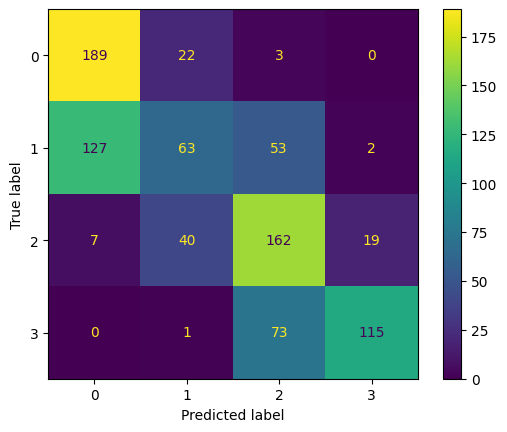

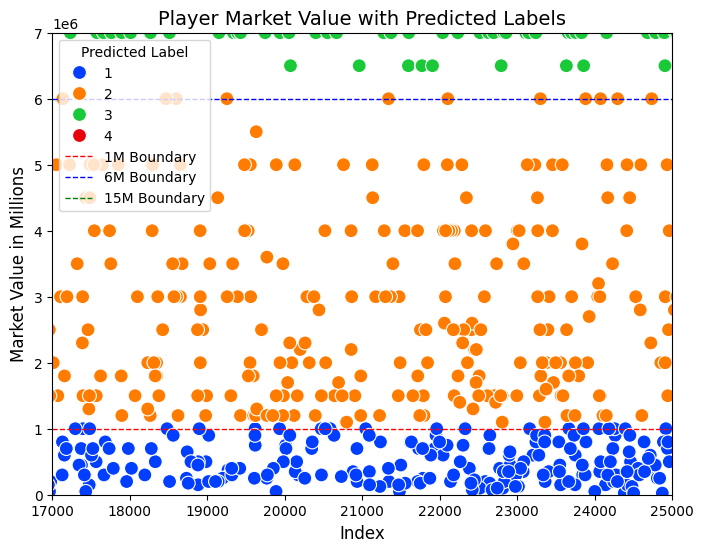

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

Y_test_pred_log = model.predict(X_test)
Y_train_pred_log = model.predict(X_train)

# Showing some parameters of the training data to confirm that the results are better
print('Train Accuracy: ', accuracy_score(Y_train, Y_train_pred_log))
print('Train F1: ', f1_score(Y_train, Y_train_pred_log, average='weighted'))
print('\n')

# Testing parameters
print('Test Accuracy: ', accuracy_score(Y_test, Y_test_pred_log))
print('Test F1 Score: ', f1_score(Y_test, Y_test_pred_log, average='weighted')) # To make sure that the contribution of each class is equal
print('Test Precision: ', precision_score(Y_test, Y_test_pred_log, average='weighted'))
print('Test Recall: ', recall_score(Y_test, Y_test_pred_log, average='weighted'))
print('Test Classification_report: \n')
print(classification_report(Y_test, Y_test_pred_log))
print('Test Confusion Matrix: \n')
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_test_pred_log))
disp.plot()
plt.show()

# Plotting the data predictions
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=dt.index, y=dt['market_value_orig'], hue=dt['Classification_Label'] , data=dt, palette='bright', s=100)
plt.ylim(0_000_000, 7_000_000)
plt.xlim(17000, 25000)
# Add horizontal lines at boundaries
plt.axhline(y=1_000_000, color='red', linestyle='--', linewidth=1, label='1M Boundary')
plt.axhline(y=6_000_000, color='blue', linestyle='--', linewidth=1, label='6M Boundary')
plt.axhline(y=15_000_000, color='green', linestyle='--', linewidth=1, label='15M Boundary')

# Add labels and title
plt.title('Player Market Value with Predicted Labels', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Market Value in Millions', fontsize=12)

# Display the plot
plt.legend(title='Predicted Label')
plt.show()


ExactExplainer explainer: 2043it [00:30, 51.87it/s]                          


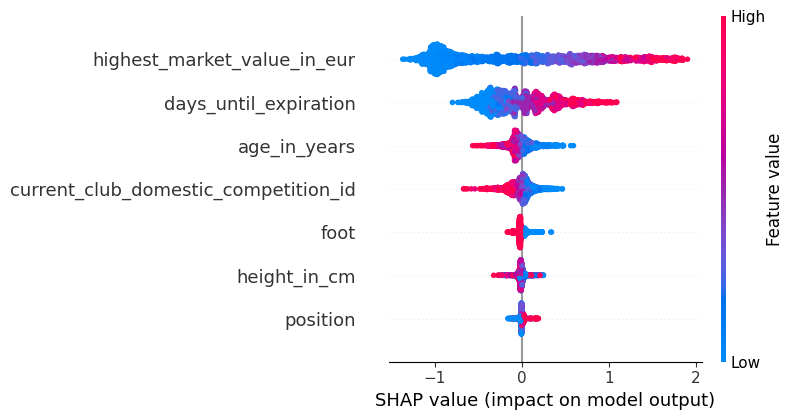

In [37]:
# Features impact
# Initialize the SHAP explainer for the linear regression model
explainer = shap.Explainer(model.predict, X_train)

# Calculate SHAP values
shap_values = explainer(X_train)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_train)

For the logistic regression classification model, we have two features that have had a great impact on the predictions. These features are the highest market value and the days until expiration of the contract. These two features have been really important to predict the classification label of the players market value.

SVM Linear Classifier (Support Vector Machine)

Accuracy: 0.6164383561643836
F1 Score: 0.6033475213596807
Precision: 0.6240700923359936
Recall: 0.6164383561643836
Classification Report:
               precision    recall  f1-score   support

           1       0.61      0.85      0.71       214
           2       0.53      0.34      0.41       245
           3       0.57      0.72      0.63       228
           4       0.82      0.59      0.69       189

    accuracy                           0.62       876
   macro avg       0.63      0.62      0.61       876
weighted avg       0.62      0.62      0.60       876

Confusion Matrix:


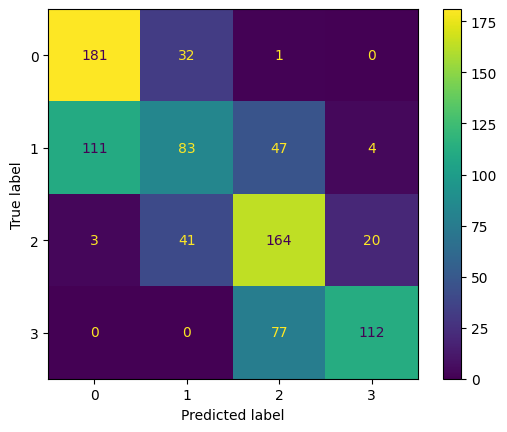

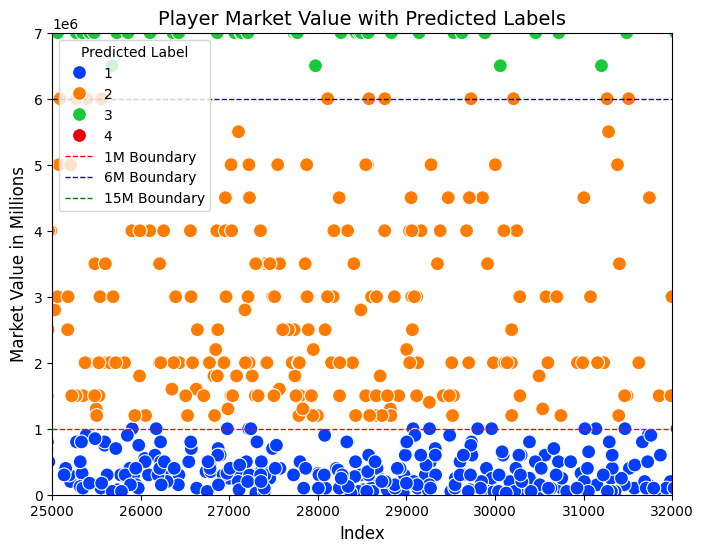

In [36]:
from sklearn.svm import SVC

# Initialize the linear SVM classifier
linear_svm = SVC(kernel='linear')

# Train the model
linear_svm.fit(X_train, Y_train)

# Make predictions
Y_train_pred = linear_svm.predict(X_train)
Y_test_pred = linear_svm.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(Y_test, Y_test_pred))
print('F1 Score:', f1_score(Y_test, Y_test_pred, average='weighted'))
print('Precision:', precision_score(Y_test, Y_test_pred, average='weighted'))
print('Recall:', recall_score(Y_test, Y_test_pred, average='weighted'))
print('Classification Report:\n', classification_report(Y_test, Y_test_pred))

# Plot the confusion matrix
print('Confusion Matrix:')
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_test_pred))
disp.plot()
plt.show()


# Plotting the data predictions
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=dt.index, y=dt['market_value_orig'], hue=dt['Classification_Label'] , data=dt, palette='bright', s=100)
plt.ylim(0_000_000, 7_000_000)
plt.xlim(25000, 32000)

# Add horizontal lines at boundaries
plt.axhline(y=1_000_000, color='red', linestyle='--', linewidth=1, label='1M Boundary')
plt.axhline(y=6_000_000, color='blue', linestyle='--', linewidth=1, label='6M Boundary')
plt.axhline(y=15_000_000, color='green', linestyle='--', linewidth=1, label='15M Boundary')

# Add labels and title
plt.title('Player Market Value with Predicted Labels', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Market Value in Millions', fontsize=12)

# Display the plot
plt.legend(title='Predicted Label')
plt.show()

ExactExplainer explainer: 2043it [21:10,  1.60it/s]


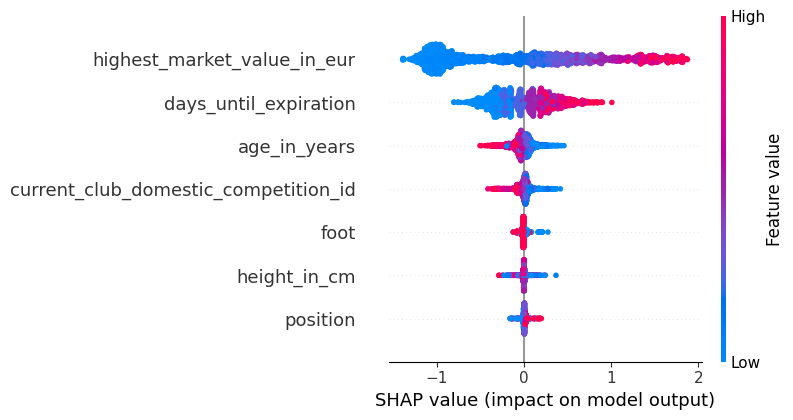

In [38]:
# Features impact
# Initialize the SHAP explainer for the linear regression model
explainer = shap.Explainer(linear_svm.predict, X_train)

# Calculate SHAP values
shap_values = explainer(X_train)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_train)

In the linear SVM classification model, we have two features that have had a great impact on the predictions. These features are the highest market value and the days until expiration of the contract. These two features have been really important to predict the classification label of the players market value. Other features like the position have not been that important.

MLP Classifier

Train Accuracy:  0.8055827619980411
Train F1:  0.8022707628755957


Test Accuracy:  0.7602739726027398
Test F1 Score:  0.7554371134266239
Test Precision:  0.7625244898394669
Test Recall:  0.7602739726027398
Test Classification_report: 

              precision    recall  f1-score   support

           1       0.74      0.90      0.81       214
           2       0.75      0.57      0.65       245
           3       0.72      0.78      0.75       228
           4       0.86      0.83      0.84       189

    accuracy                           0.76       876
   macro avg       0.77      0.77      0.76       876
weighted avg       0.76      0.76      0.76       876

Test Confusion Matrix: 



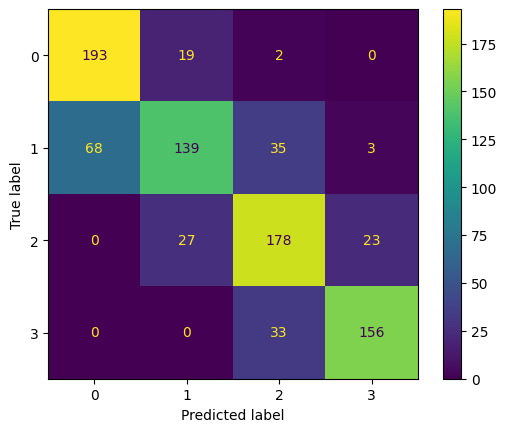

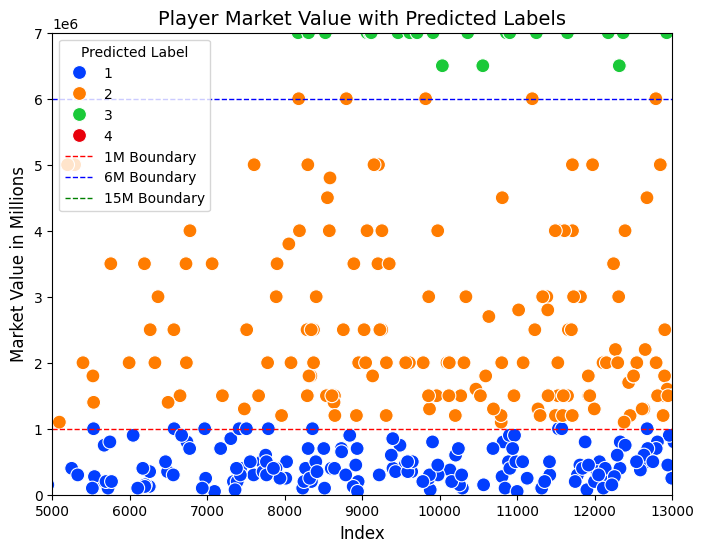

In [39]:
from sklearn.neural_network import MLPClassifier
# Create a neural network with a hidden layer of size 100
MLP = MLPClassifier(activation='logistic', hidden_layer_sizes=(100,), max_iter=2000, solver='adam')
MLP.fit(X_train, Y_train)

Y_test_pred_MLP = MLP.predict(X_test)
Y_train_pred_MLP = MLP.predict(X_train)

# Showing some parameters of the training data to confirm that the results are better
print('Train Accuracy: ', accuracy_score(Y_train, Y_train_pred_MLP))
print('Train F1: ', f1_score(Y_train, Y_train_pred_MLP, average='weighted'))
print('\n')

# Save it in a variable for future use
f1_MLP = f1_score(Y_test, Y_test_pred_MLP, average='weighted')

# Testing parameters
print('Test Accuracy: ', accuracy_score(Y_test, Y_test_pred_MLP))
print('Test F1 Score: ', f1_MLP) # To make sure that the contribution of each class is equal
print('Test Precision: ', precision_score(Y_test, Y_test_pred_MLP, average='weighted'))
print('Test Recall: ', recall_score(Y_test, Y_test_pred_MLP, average='weighted'))
print('Test Classification_report: \n')
print(classification_report(Y_test, Y_test_pred_MLP))
print('Test Confusion Matrix: \n')
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_test_pred_MLP))
disp.plot()
plt.show()

# Plotting the data predictions
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=dt.index, y=dt['market_value_orig'], hue=dt['Classification_Label'] , data=dt, palette='bright', s=100)
plt.ylim(0_000_000, 7_000_000)
plt.xlim(5000, 13000)
# Add horizontal lines at boundaries
plt.axhline(y=1_000_000, color='red', linestyle='--', linewidth=1, label='1M Boundary')
plt.axhline(y=6_000_000, color='blue', linestyle='--', linewidth=1, label='6M Boundary')
plt.axhline(y=15_000_000, color='green', linestyle='--', linewidth=1, label='15M Boundary')

# Add labels and title
plt.title('Player Market Value with Predicted Labels', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Market Value in Millions', fontsize=12)

# Display the plot
plt.legend(title='Predicted Label')
plt.show()


ExactExplainer explainer: 2043it [09:43,  3.43it/s]


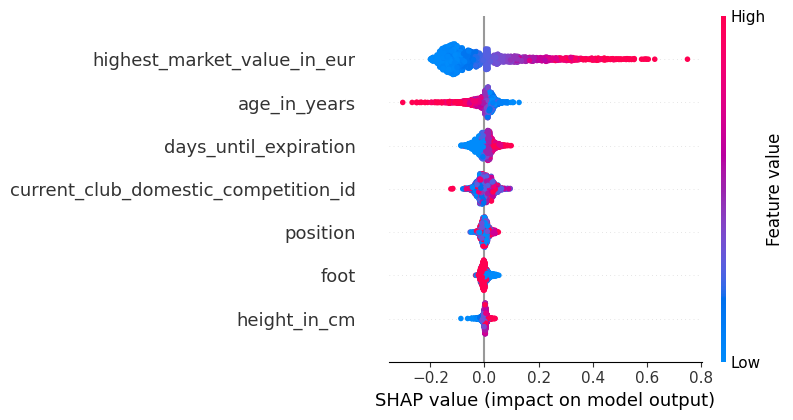

In [40]:
# Features impact
# Initialize the SHAP explainer for the linear regression model
explainer = shap.Explainer(best_svr.predict, X_train)

# Calculate SHAP values
shap_values = explainer(X_train)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_train)

The MLP model has been fit with the 7 features in order to make the predictions. In this process, the features with most impact have been the highest market value and the players' age in years.

Three Classification Models' comparison

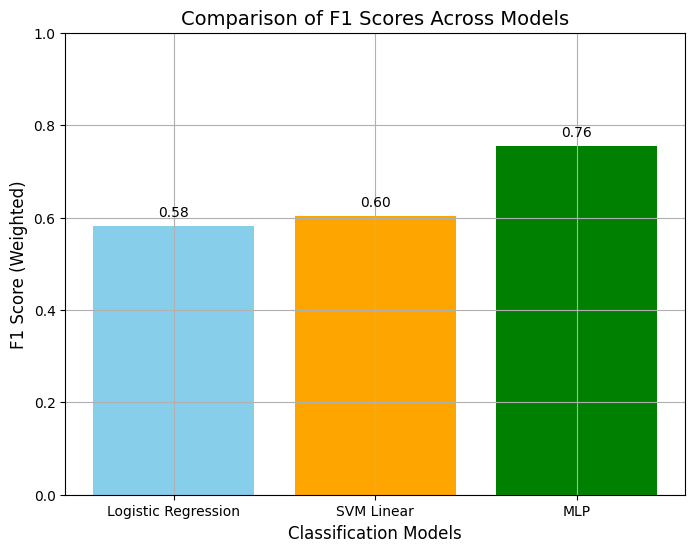

In [41]:
# Plotting the F1 Scores
f1_scores = [ f1_score(Y_test, Y_test_pred_log, average='weighted'),  # Logistic Regression
    f1_score(Y_test, Y_test_pred, average='weighted'),      # SVM Linear
    f1_score(Y_test, Y_test_pred_MLP, average='weighted')   # Neural Network
]


models = ['Logistic Regression', 'SVM Linear', 'MLP']

plt.figure(figsize=(8, 6))
plt.bar(models, f1_scores, color=['skyblue', 'orange', 'green'])
plt.ylim(0, 1)  # F1 score ranges between 0 and 1
plt.title('Comparison of F1 Scores Across Models', fontsize=14)
plt.xlabel('Classification Models', fontsize=12)
plt.ylabel('F1 Score (Weighted)', fontsize=12)

for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)

plt.grid()

We can clearly see that the Classification metrics are higher and therefore better if we use a Neural Network with perceptrons.

## **6- Unsupervised + Supervised Learning**

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = dt.drop(columns=['Classification_Label','market_value_in_eur','market_value_orig'])

sse = []
slc = []
for k in range (2,13):
  kmeans = KMeans(n_clusters=k, init='random')
  kmeans.fit(features)
  sse.append(kmeans.inertia_)
  slc.append(silhouette_score(features, kmeans.labels_))

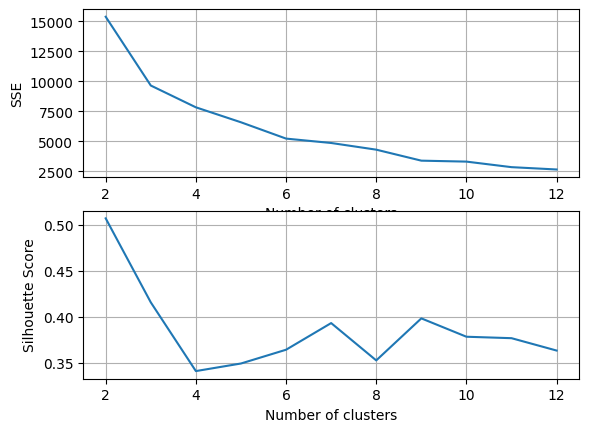

In [47]:
plt.subplot(2,1,1)
plt.plot(range(2,13), sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.grid()

plt.subplot(2,1,2)
plt.plot(range(2,13), slc)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid()


From the SSE plot we see that the graphic slope changes from 6 to 7 but it doesn´t change much from 7 to 8.
In the Silhouette plot we can also see a peak in number 7 so I am selecting 7 clusters.

In [51]:
kmeans = KMeans(n_clusters=7, init='random')
kmeans = kmeans.fit(features)
# Get the cluster labels
clusters = kmeans.predict(features)
#Get the centroid values
centroids = kmeans.cluster_centers_

(5000.0, 13000.0)

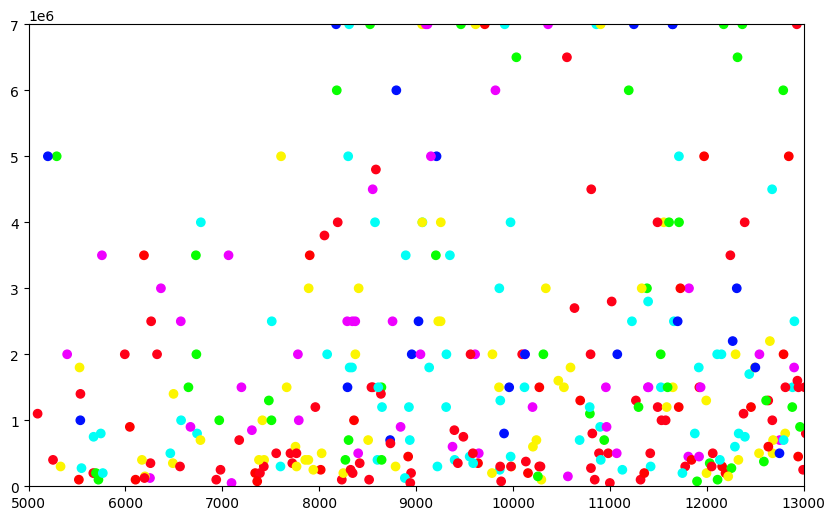

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(dt.index, dt['market_value_orig'], c=clusters, cmap='hsv')
plt.ylim(0_000_000, 7_000_000)
plt.xlim(5000, 13000)

In [54]:
print(kmeans.n_iter_)
print(kmeans.inertia_)

8
4505.934895639649


In [55]:
# REGRESSION PER CLUSTER
# Add clustering labels to the dataset
X = dt.drop(columns=['Classification_Label','market_value_in_eur','market_value_orig']) # I want to train the model without the labels
Y = dt['market_value_in_eur'] # The Regression label

X_with_clusters = X.copy()
X_with_clusters['Cluster'] = clusters

# Create train-test split again with cluster information
X_train, X_test, Y_train, Y_test = train_test_split(X_with_clusters, Y, test_size=0.3, random_state=42)

# Initialize list to store results
regression_cluster_mse = []

# Iterate over each cluster
for cluster in range(kmeans.n_clusters):
    print(f"\nCluster {cluster}")
    cluster_train_idx = X_train['Cluster'] == cluster
    cluster_test_idx = X_test['Cluster'] == cluster

    # Filter train and test sets for the current cluster
    X_cluster_train = X_train[cluster_train_idx].drop(columns=['Cluster'])
    Y_cluster_train = Y_train[cluster_train_idx]

    X_cluster_test = X_test[cluster_test_idx].drop(columns=['Cluster'])
    Y_cluster_test = Y_test[cluster_test_idx]

    # Polynomial Regression
    regressor = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    regressor.fit(X_cluster_train, Y_cluster_train)
    Y_cluster_pred = regressor.predict(X_cluster_test)

    # Evaluate Regression
    mse = mean_squared_error(Y_cluster_test, Y_cluster_pred)
    r2 = r2_score(Y_cluster_test, Y_cluster_pred)
    cluster_size = len(Y_cluster_test) # Get cluster size to calculate the average
    regression_cluster_mse.append((cluster, mse, r2, cluster_size))
    print(f"Regression\n MSE: {mse}, R^2: {r2}, Cluster Size: {cluster_size}")

#  Results
print("\nRegression Results Per Cluster:")
for cluster, mse, r2, cluster_size in regression_cluster_mse:
    print(f"Cluster {cluster}: MSE = {mse}, R^2 = {r2}, cluster size = {cluster_size}")


Cluster 0
Regression
 MSE: 0.003138748925708781, R^2: 0.8301454005958611, Cluster Size: 112

Cluster 1
Regression
 MSE: 0.0029760884403372944, R^2: 0.8748080011877546, Cluster Size: 135

Cluster 2
Regression
 MSE: 0.010021559551206568, R^2: 0.665790426736444, Cluster Size: 116

Cluster 3
Regression
 MSE: 0.007936598466630812, R^2: 0.7690689183235566, Cluster Size: 133

Cluster 4
Regression
 MSE: 0.021674503325682822, R^2: 0.5898077602758707, Cluster Size: 116

Cluster 5
Regression
 MSE: 0.008993587304175264, R^2: 0.8163786273228031, Cluster Size: 136

Cluster 6
Regression
 MSE: 0.0013148408551696118, R^2: 0.7124987538277228, Cluster Size: 128

Regression Results Per Cluster:
Cluster 0: MSE = 0.003138748925708781, R^2 = 0.8301454005958611, cluster size = 112
Cluster 1: MSE = 0.0029760884403372944, R^2 = 0.8748080011877546, cluster size = 135
Cluster 2: MSE = 0.010021559551206568, R^2 = 0.665790426736444, cluster size = 116
Cluster 3: MSE = 0.007936598466630812, R^2 = 0.7690689183235566

In [56]:
# CLASSIFICATION PER CLUSTER
# Add clustering labels to the dataset
X = dt.drop(columns=['Classification_Label','market_value_in_eur','market_value_orig']) # I want to train the model without the labels
Y = dt['Classification_Label'] # The Classification label

X_with_clusters = X.copy()
X_with_clusters['Cluster'] = clusters

# Create train-test split again with cluster information
X_train, X_test, Y_train, Y_test = train_test_split(X_with_clusters, Y, test_size=0.3, random_state=42)

# Initialize list to store results
classification_cluster_f1 = []

# Iterate over each cluster
for cluster in range(kmeans.n_clusters):
    print(f"\nCluster {cluster}")
    cluster_train_idx = X_train['Cluster'] == cluster
    cluster_test_idx = X_test['Cluster'] == cluster

    # Filter train and test sets for the current cluster
    X_cluster_train = X_train[cluster_train_idx].drop(columns=['Cluster'])
    Y_cluster_train = Y_train[cluster_train_idx]

    X_cluster_test = X_test[cluster_test_idx].drop(columns=['Cluster'])
    Y_cluster_test = Y_test[cluster_test_idx]

    # MLP Classification
    classifier = MLPClassifier(activation='logistic', hidden_layer_sizes=(100,), max_iter=7500, solver='adam')
    classifier.fit(X_cluster_train, Y_cluster_train)
    Y_cluster_pred_class = classifier.predict(X_cluster_test)

    # Evaluate Classification
    f1 = f1_score(Y_cluster_test, Y_cluster_pred_class, average='weighted')
    cluster_size = len(Y_cluster_test) # Get cluster size to calculate the average
    classification_cluster_f1.append((cluster, f1, cluster_size))
    print(f"Classification\n F1 Score: {f1}")

# Results
print("\nClassification Results Per Cluster vs Standalone Model:")
for cluster, f1, size in classification_cluster_f1:
    print(f"Cluster {cluster}: F1 Score = {f1}, cluster_size = {size}")


Cluster 0
Classification
 F1 Score: 0.7055283837673

Cluster 1
Classification
 F1 Score: 0.6842938745426308

Cluster 2
Classification
 F1 Score: 0.5908352055963838

Cluster 3
Classification
 F1 Score: 0.6284099136730716

Cluster 4
Classification
 F1 Score: 0.7932862579951722

Cluster 5
Classification
 F1 Score: 0.625833881402439

Cluster 6
Classification
 F1 Score: 0.6483957268347141

Classification Results Per Cluster vs Standalone Model:
Cluster 0: F1 Score = 0.7055283837673, cluster_size = 112
Cluster 1: F1 Score = 0.6842938745426308, cluster_size = 135
Cluster 2: F1 Score = 0.5908352055963838, cluster_size = 116
Cluster 3: F1 Score = 0.6284099136730716, cluster_size = 133
Cluster 4: F1 Score = 0.7932862579951722, cluster_size = 116
Cluster 5: F1 Score = 0.625833881402439, cluster_size = 136
Cluster 6: F1 Score = 0.6483957268347141, cluster_size = 128


Comparison Clustering + Regression vs Regression

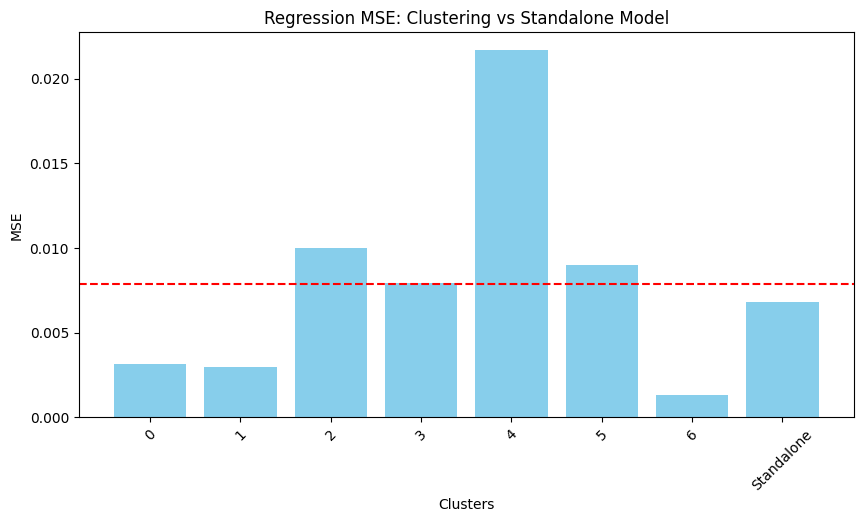

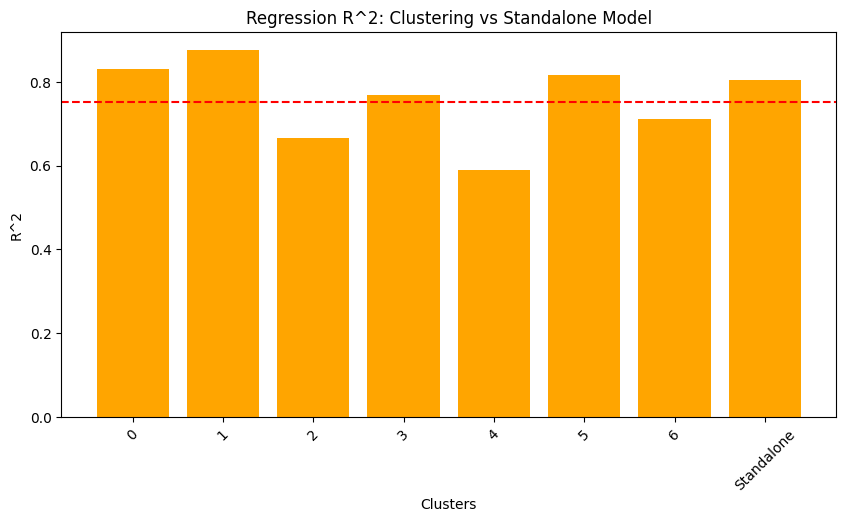

In [57]:
standalone_regression_mse = mse_test_poly
standalone_regression_r2 = r2_test_poly

# Data for clustering-based models
# Assuming regression_cluster_mse = [(cluster_id, mse, r2), ...]
# And classification_cluster_f1 = [(cluster_id, f1), ...]
clusters = [str(entry[0]) for entry in regression_cluster_mse]
regression_mse = [entry[1] for entry in regression_cluster_mse]
regression_r2 = [entry[2] for entry in regression_cluster_mse]

cluster_sizes = [entry[3] for entry in regression_cluster_mse]  # Extract sizes

# Calculate weighted mean of MSE
total_values = sum(cluster_sizes)
weighted_mean_regression_mse = sum(mse * size for mse, size in zip(regression_mse, cluster_sizes)) / total_values
weighted_mean_regression_r2 = sum(r2 * size for r2, size in zip(regression_r2, cluster_sizes)) / total_values


# Add standalone model metrics to clusters for comparison
clusters.append("Standalone")
regression_mse.append(standalone_regression_mse)
regression_r2.append(standalone_regression_r2)

# Plot Regression MSE
mean_regression_mse = sum(regression_mse[:-1]) / len(regression_mse[:-1])  # Exclude standalone
plt.figure(figsize=(10, 5))
plt.bar(clusters, regression_mse, color='skyblue')
plt.axhline(weighted_mean_regression_mse, color='red', linestyle='--', label=f'Mean MSE: {weighted_mean_regression_mse:.2f}')
plt.title('Regression MSE: Clustering vs Standalone Model')
plt.ylabel('MSE')
plt.xlabel('Clusters')
plt.xticks(rotation=45)
plt.show()

# Plot Regression R^2
mean_regression_r2 = sum(regression_r2[:-1]) / len(regression_r2[:-1])  # Exclude standalone
plt.figure(figsize=(10, 5))
plt.bar(clusters, regression_r2, color='orange')
plt.axhline(mean_regression_r2, color='red', linestyle='--', label=f'Mean R^2: {mean_regression_r2:.2f}')
plt.title('Regression R^2: Clustering vs Standalone Model')
plt.ylabel('R^2')
plt.xlabel('Clusters')
plt.xticks(rotation=45)
plt.show()

**MSE Analysis**

When comparing Mean Squared Error (MSE), there are some clusters that perform better than the standalone regression, while others like cluster 4 show higher MSE. The weighted average MSE is slightly higher than the standalone model, but the difference is minimal, indicating no significant error introduced by clustering. While clustering doesn’t clearly reduce errors, the overall MSE levels remain negligible and acceptable.

**R² Analysis**

For the R² metric the standalone regression model outperforms the clustering + regression. Cluster 4, significantly lower the cluster average R² and, as a consequence, the standalone regression achieves a higher R² value (> 0.8).
There also exists variability in performance between clusters, resulting in a lower weighted average R² compared to the standalone regression. This indicates that clustering does not effectively enhance the regression model.

As a **conclusion**, based on these results, clustering combined with regression does not improve the performance metrics (MSE and R²) over the standalone regression model. While the MSE differences are minimal and not problematic, the overall R² reduction indicates that the standalone regression model is more robust and reliable for this particular task.

Comparison Clustering + Classification vs Classification

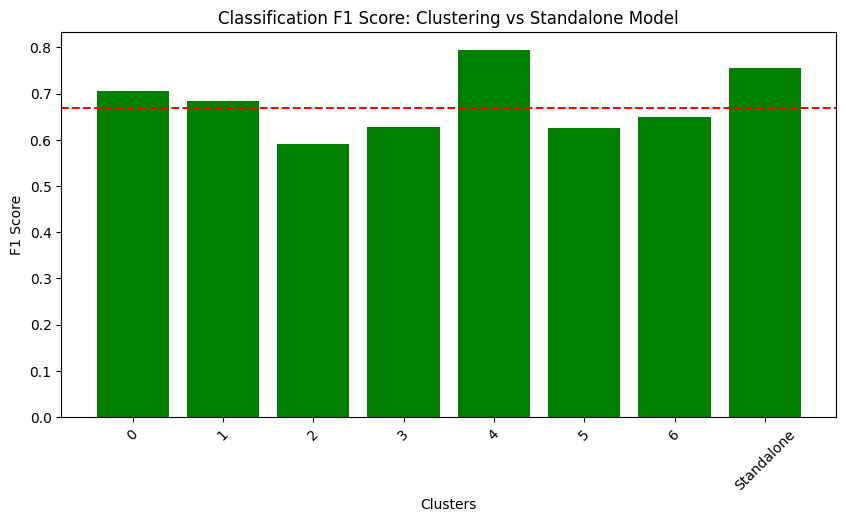

In [58]:
standalone_classification_f1 = f1_MLP
classification_f1 = [entry[1] for entry in classification_cluster_f1]
classification_f1.append(standalone_classification_f1)

clts = [str(i) for i in range(len(classification_cluster_f1))]
clts.append("Standalone")
# Calculate and annotate mean for Classification F1 Score
mean_classification_f1 = sum(classification_f1[:-1]) / len(classification_f1[:-1])  # Exclude standalone

# Plot Classification F1 Score
plt.figure(figsize=(10, 5))
plt.bar(clts, classification_f1, color='green')
plt.axhline(mean_classification_f1, color='red', linestyle='--', label=f'Mean F1: {mean_classification_f1:.2f}')
plt.title('Classification F1 Score: Clustering vs Standalone Model')
plt.ylabel('F1 Score')
plt.xlabel('Clusters')
plt.xticks(rotation=45)
plt.show()


For the **F1 score**, the standalone classification model outperforms the clustering + classification approach, achieving a higher value close to 0.8. Contrary to the clustering overall average which is almost 0.7. This indicates that clustering does not improve and is not suitable for classification with this dataset.

## **7- Conclusions**

In this project, I explored both regression and classification tasks to predict soccer players' market value. The dataset and its characteristics played a significant role in determining the success of different models and approaches.


The **regression** task aimed to predict market_value_in_eur. After testing various models, Polynomial Regression outperformed others, including Linear Regression and Support Vector Regression (SVR) with hyperparameter tuning (via grid search). The success of Polynomial Regression can be attributed to its ability to capture non-linear relationships, which are likely present in this dataset, where the value of soccer players may not increase linearly with features like age or highest market value.

The **selected features** had high impact on the models´ predictions. The features selected have been:

*   Position and Foot: These qualitative features were encoded, contributing valuable categorical distinctions.
*   Height and Age: Quantitative physical attributes of players.
*   Highest Market Value: A strong predictor that directly correlates with the target label.
*   Current Club Competition and Days Until Expiration: Contextual features offering insight into the player's environment and contract status.

This combination of features allowed the model to include intrinsic player characteristics and external context effectively.


The **classification** task used Classification_Label as the label that aimed to predict. The MLP Classifier (a neural network with one hidden layer of size 100) was the most successful model. Its ability to capture complex patterns and interactions between features made it the most effective for this dataset. Simpler models like logistic regression and linear classifiers had less precision on modelling the non-linearities and features relations.

For **Clustering** I decided to use KMeans and the result was that it did not enhance the results for either regression or classification. This suggests that the dataset did not have distinct or separable clusters that could improve supervised learning. While clustering is a valid approach and may benefit other datasets, its inefficiency here shows that not every dataset benefits from unsupervised methods. Their efficiency depends on the unique structure of the data.


The **best models** were Polynomial Regression for the regression task and the MLP Classifier for classification. Thanks to metrics like F1 Score, R^2 and MSE, I proved that these models provided the most accurate and reliable results.

As a final **conclusion**, the results demonstrate that understanding the dataset is as important as applying complex techniques. The implementetion of clustering and the lack of improvement surprised me a lot. But I learned that the challenges I faced and the results I got, are highly dependant on characteristics of the dataset. Polynomial Regression and MLP were chosen as preferred models because they effectively addressed the dataset's complexity and captured its non-linearities. These results align with the course objectives and provide a solid foundation for facing similar challenges and projects with other datasets in the future.